# **Assignment Two: Generative Model**


## Context:

---
The goal of this exercise is to create a generative adversarial network to reproduce the tabular data found https://github.com/JeffersonLab/jlab_datascience_data/blob/main/eICU_age.npy. The dataset includes the ages of critical care patients seen across intensive care units in the United States. The original data is from the eICU Collaborative Research Database https://eicu-crd.mit.edu/about/eicu/. To solve this problem implement a generative adversarial network (GAN) in python to produce the distribution of age for these patients. Your script must coordinate both the generator and discriminator models. Please provide figures to illustrate this coordination and compare the distribution from the generator model output with that of the true distribution.

---




> Indented block




---
## **Importing necessary libraries**
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import pandas as pd
import seaborn as sns
from scipy.stats import entropy


---
## **Load Data**
---

In [2]:
# Load dataset
data_url = "https://github.com/JeffersonLab/jlab_datascience_data/blob/main/eICU_age.npy?raw=true"
ages = np.load(tf.keras.utils.get_file("eICU_age.npy", data_url))
df = pd.DataFrame(ages)

---
## **Explotary Data Analysis (EDA)**
---

In [3]:
# Display first five rows
df.head()

,age
0,87
1,87
2,76
3,34
4,61


In [4]:
# display last five rows
df.head()

,age
0,87
1,87
2,76
3,34
4,61


In [5]:
# shape of the data
df.shape

(2520, 1)

In [6]:
# data the data type of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520 entries, 0 to 2519
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     2520 non-null   int8 
dtypes: int8(1)
memory usage: 2.6 KB


In [7]:
# check the statistical summary of the dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,2520.0,63.284524,17.725186,15.0,53.0,66.0,77.0,90.0


In [8]:
# check if there is any negative value in the data set
df.loc[df['age']<0].shape

(0, 1)

In [9]:
# check for missing values
df.isnull().sum()

age    0
dtype: int64

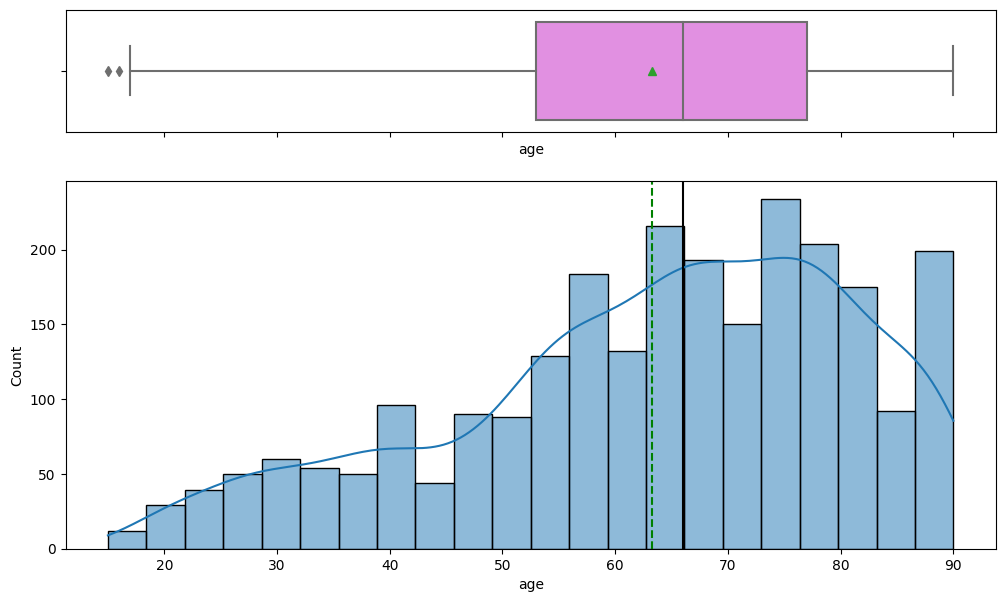

In [10]:
# Visualize the distribution of the dataset 

# function to plot a boxplot and a histogram along the same scale.
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram
    
histogram_boxplot(pd.DataFrame(ages), 'age', figsize=(12, 7), kde=True, bins=None)

---
## **Data Preprocessing: Prepare the data for model building**
---

In [11]:
# Normalize the ages by dividing by the maximum age
ages_temp = df.to_numpy()
max_age = max(ages_temp)
ages_normalized = ages_temp / max_age

---
## **Model Building**
---

In [12]:
# Create generator model
def create_generator(input_dim):
    model = Sequential()
    model.add(Dense(128, activation="relu", input_dim=input_dim))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    return model

input_dim = 100
generator = create_generator(input_dim)

In [13]:
# Create discriminator model
def create_discriminator():
    model = Sequential()
    model.add(Dense(64, activation="relu", input_dim=1))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    return model

discriminator = create_discriminator()

In [14]:
# Define custom learning rates for generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)

# Define custom binary cross entropy loss function
loss_fcn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
#loss_fcn = tf.keras.losses.MeanSquaredError()

In [15]:
# Custom training function for GAN using GradientTape
@tf.function
def train_step(real_ages):
    batch_size = real_ages.shape[0]
    
    # Train discriminator
    noise = tf.random.normal([batch_size, input_dim]) # create a noise vector as generator input sampled from Gaussian Random Normal
    generated_ages = generator(noise, training=True)
    
    real_labels = tf.ones((batch_size, 1)) # the original data is real, labeled with 1
    fake_labels = tf.zeros((batch_size, 1))  # the forged data is fake, labeled with 0

    with tf.GradientTape() as tape:
        real_output = discriminator(real_ages, training=True) 
        fake_output = discriminator(generated_ages, training=True) # see if the discriminator detects them
        
        d_loss_real = loss_fcn(real_labels, real_output)  # calculate the loss function 
        d_loss_fake = loss_fcn(fake_labels, fake_output)
        d_loss = d_loss_real + d_loss_fake
    
    # apply the backward path and update weights
    discriminator_gradients = tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    # Train generator
    noise = tf.random.normal([batch_size, input_dim])
    
    with tf.GradientTape() as gen_tape:
        generated_ages = generator(noise, training=True)
        fake_output = discriminator(generated_ages, training=False)
        
        g_loss = loss_fcn(real_labels, fake_output)

    generator_gradients = gen_tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

    return d_loss, g_loss # return the loss for visualization

---
## **Model Training**
---

In [16]:
# Train the GAN
def train_gan(epochs, batch_size,kl_threshold):
    for epoch in range(epochs):
        indices = np.random.randint(0, len(ages_normalized), batch_size)
        real_ages = ages_normalized[indices]
        real_ages = tf.constant(real_ages, dtype=tf.float32)

        d_loss, g_loss = train_step(real_ages)
        if epoch % 10 == 0:
            # Generate fake ages
            noise = tf.random.normal([len(ages_normalized), input_dim])
            generated_ages = generator(noise, training=False).numpy().flatten()

            # Calculate KL divergence
            real_hist, _ = np.histogram(ages_normalized, bins=100, density=True)
            gen_hist, _ = np.histogram(generated_ages, bins=100, density=True)
            real_hist += 1e-8  # Add small value to avoid division by zero
            gen_hist += 1e-8
            kl_divergence = entropy(real_hist, gen_hist)
            
            # log the performance
            print(f"Epoch: {epoch}, D loss: {d_loss}, G loss: {g_loss}, KL divergence: {kl_divergence}")

            # Check if KL divergence is below the threshold
            if kl_divergence <= kl_threshold:
                print("Reached KL divergence threshold. Stopping training.")
                break

epochs = 5000
batch_size = 128
kl_threshold = 0.4
train_gan(epochs,batch_size,kl_threshold)

Epoch: 0, D loss: 1.3839311599731445, G loss: 0.681047797203064, KL divergence: 0.9289282761816939
Epoch: 10, D loss: 1.3840789794921875, G loss: 0.6716339588165283, KL divergence: 1.6685518133505088
Epoch: 20, D loss: 1.3862744569778442, G loss: 0.6726314425468445, KL divergence: 0.7804587188802974
Epoch: 30, D loss: 1.3892474174499512, G loss: 0.6897519826889038, KL divergence: 1.311250004993329
Epoch: 40, D loss: 1.3886499404907227, G loss: 0.7159241437911987, KL divergence: 0.8028047513185802
Epoch: 50, D loss: 1.386566400527954, G loss: 0.7376675605773926, KL divergence: 1.309547013377543
Epoch: 60, D loss: 1.381450891494751, G loss: 0.7518086433410645, KL divergence: 0.8684702022312498
Epoch: 70, D loss: 1.379443645477295, G loss: 0.7538518905639648, KL divergence: 1.3716182709051319
Epoch: 80, D loss: 1.3846962451934814, G loss: 0.7398927211761475, KL divergence: 0.9389243106083148
Epoch: 90, D loss: 1.391345739364624, G loss: 0.7087958455085754, KL divergence: 2.006476212529991

---
## **Model Performance**
---

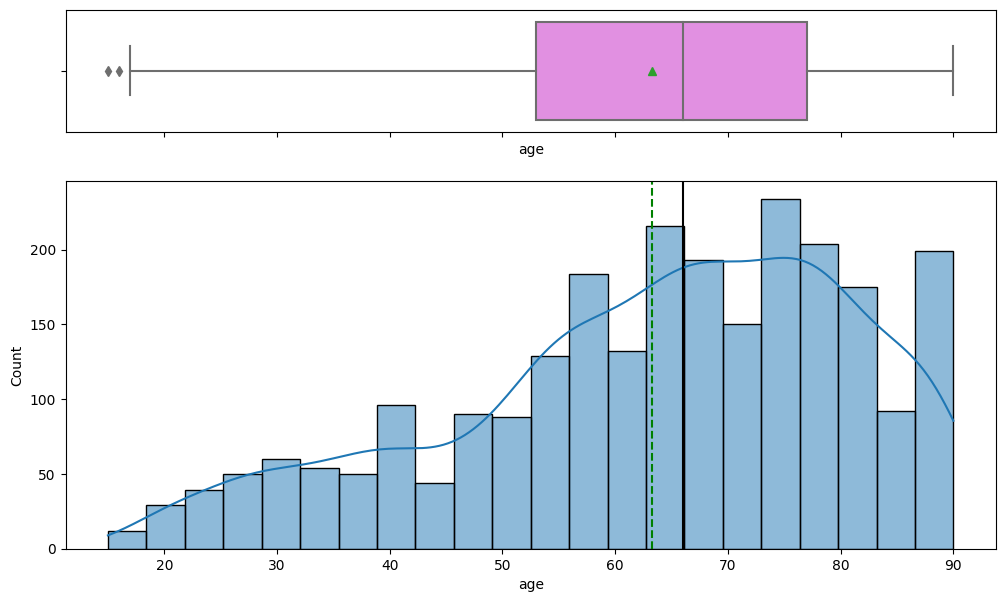

In [17]:
histogram_boxplot(pd.DataFrame(ages), 'age', figsize=(12, 7), kde=True, bins=None)

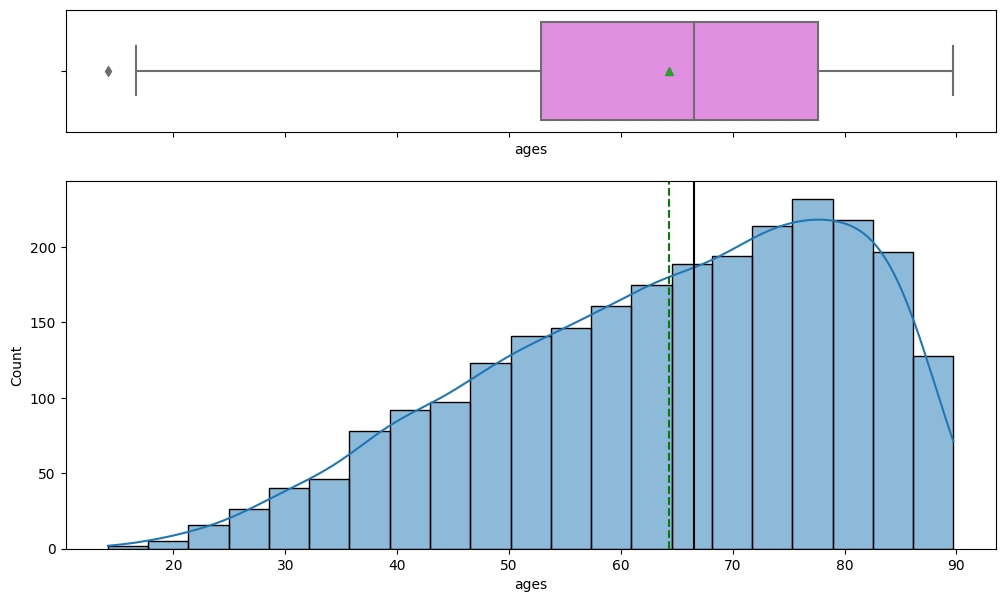

In [18]:
# synthesize ages using the trained generator 
noise = tf.random.normal([len(ages_normalized), input_dim])
generated_ages = generator(noise).numpy().flatten()* max_age
histogram_boxplot(pd.DataFrame(generated_ages,columns=['ages']), 'ages', figsize=(12, 7), kde=True, bins=None)

---
## **Observations**
---

* The model was found to be highly unstable during the training process.  
* The network was found to very sensitivite to the hyperparameters.
* Difficult to tune the model to acheive satisfactory results.




---
## **Convert notbook to HTML file**
---

In [19]:
# access the google drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# convert to html
%%shell
jupyter nbconvert --to html ///content/drive/MyDrive/JLAB/GAN/testing/GAN.ipynb

[NbConvertApp] Converting notebook ///content/drive/MyDrive/JLAB/GAN/testing/GAN.ipynb to html
[NbConvertApp] Writing 788217 bytes to /content/drive/MyDrive/JLAB/GAN/testing/GAN.html
